# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">


## Gaussian Mixture Model

In [1]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}|
</style>
""")

## My own latex definitions
$\require{color}$
$$\gdef\mathbf#1{\mathbf{#1}}$$
$$\gdef\mathbf#1{\boldsymbol{#1}}$$
$$\gdef\mathbf{x}{\mathbf{x}}$$
$$\gdef\mathbf{z}{\mathbf{z}}$$
$$\gdef\mathbf{\mu}{\mathbf{\mu}}$$
$$\gdef\mathbf{\Sigma}{\mathbf{\Sigma}}$$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

font = {'family' : 'Serif',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Recap probability and Gaussian Distribution
- Maximum Likelihood Estimator
- MLE with a single Gaussian
- Applications: Anomaly Detection and Data Generation

# Today's lecture
## Gaussian Mixture Model (GMM)
## Density Estimator with GMM
## Generate data with GMM

# This lecture material is taken from
- [Cimi Book - Chapter 15](http://ciml.info/dl/v0_99/ciml-v0_99-ch15.pdf)
- [Bishop - Chapter 9.2](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
- [Stanford Kmeans](https://www.youtube.com/watch?v=LmpkKwsyQj4)
- [Stanford Kmeans](http://cs229.stanford.edu/syllabus-summer2020.html)
- [Illustrations](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch11/ch11.ipynb)
- [Code](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

# Unsupervised Learning

**Objective and Motivation:** The goal of unsupervised learning is to find **hidden patterns** in unlabeled data. 

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}


- Unlike in supervised learning, any data points is not paired with a label.

- As you can see the unsupervised learning problem is ill-posed (which hidden patterns?) and in principle more difficult than supervised learning.

- Unsupervised learning can be thought of as "finding structure" in the data.

# Gaussian Distribution

- $\mu$ is the mean
- $\Sigma$ is the covariance matrix
- $k$ is the dimension of the space where $x$  takes values
$$
   f(x) = \frac{1}{\sqrt{(2 \pi)^k \colorbox{yellow}{$\det \Sigma$}}}
               \exp\left( -\frac{1}{2} \colorbox{yellow}{$(x - \mu)^T \Sigma^{-1} (x - \mu)$} \right),
$$

# Univariate Gaussian (1-D Gaussian)


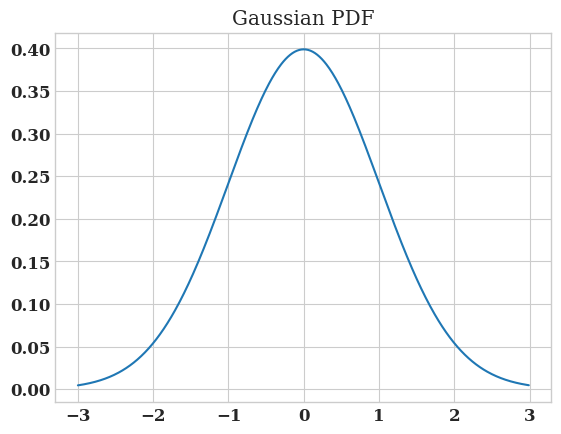

In [3]:
# Univariate Gaussian (1-D Gaussian)
mu, sigma = 0, 1
x = np.arange(-3, 3, 0.01)
p = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2 / (2 * sigma**2)) 
_ = plt.plot(x, p);
_ = plt.title('Gaussian PDF')

# Cumulative Density Function

<img src="https://d2l.ai/_images/output_distributions_c7d568_219_0.svg" />

<img src="https://d2l.ai/_images/output_integral-calculus_06e2a4_15_0.svg" />

# Multivariate Gaussian (N-D Gaussian)


- $\mu$ is the mean
- $\Sigma$ is the covariance matrix
- $k$ is the dimension of the space where $x$  takes values **(k=2 in this case)**

$$
   f(x) = \frac{1}{\sqrt{(2 \pi)^k \colorbox{yellow}{$\det \Sigma$}}}
               \exp\left( -\frac{1}{2} \colorbox{yellow}{$ (x - \mu)^T \Sigma^{-1} (x - \mu)$} \right),
$$

In [4]:
from scipy.stats import multivariate_normal
mu = [0, 0]
Sigma = [[2, 0.0],
         [0.0, 1]]
F = multivariate_normal(mu, Sigma )

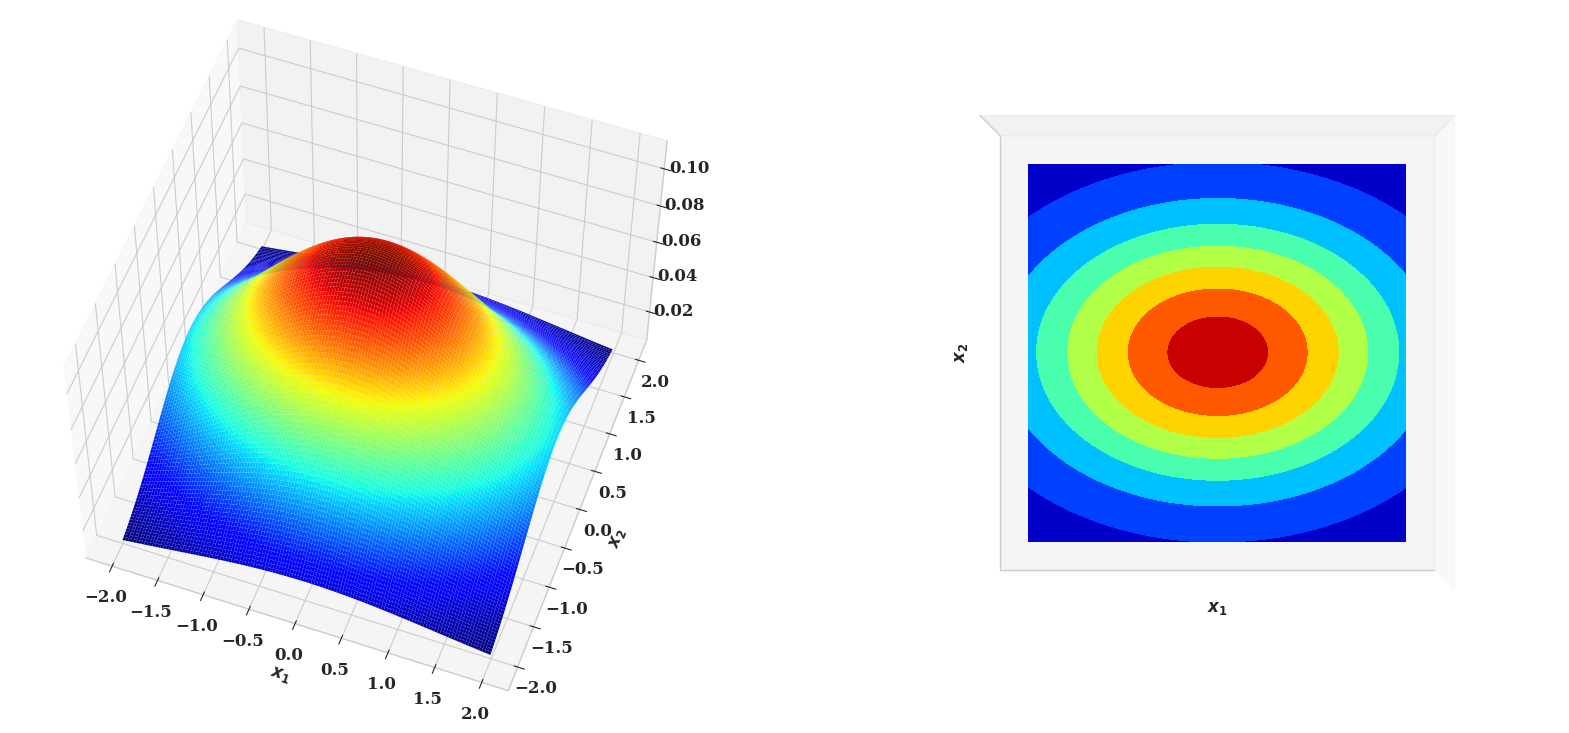

In [5]:
from scipy.stats import multivariate_normal
X, Y = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((X, Y))
Z = F.pdf(pos)

# plot using subplots
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                 cmap='jet')
ax1.view_init(55, -70)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet')
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

# The Mahalanobis distance

The Mahalanobis distance of a point $\mathbf{x}$ from a multivariate Gaussian $\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$

$$ 
D_M(\vec{x}) = \sqrt{(\mathbf{x} - \mathbf{\mu})^\mathsf{T} \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})}
$$

- It is a multi-dimensional generalization of the idea of measuring how many standard deviations away $\mathbf{x}$ is from the mean of $\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$
- This distance is zero for $\mathbf{x}$ at $\mathbf{\mu}$ and grows as $\mathbf{x}$ moves away from the mean along each principal component axis. 

- If each of these axes are re-scaled to have unit variance, then the Mahalanobis distance corresponds to **standard Euclidean** distance in the transformed space. The Mahalanobis distance is thus unitless, scale-invariant, and takes into account the correlations of the data set.

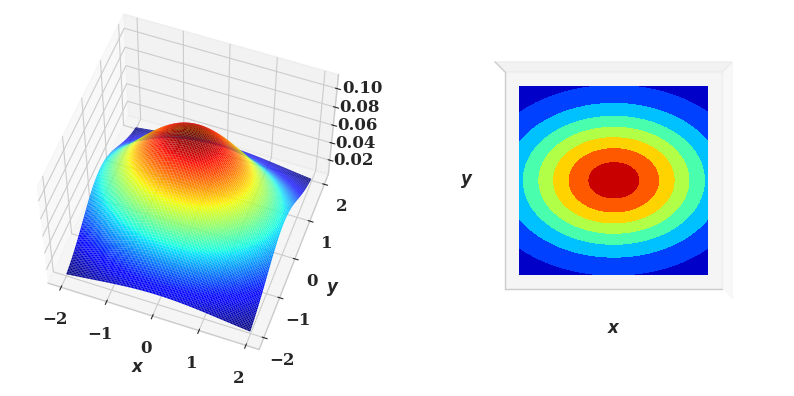

In [6]:
from scipy.stats import multivariate_normal
X, Y = np.mgrid[-2:2:0.01, -2:2:0.01]
pos = np.dstack((X, Y))
Z = F.pdf(pos)

# plot using subplots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                 cmap='jet')
ax1.view_init(55, -70)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap='jet')
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')

plt.show()

# Terminology for Statistics

<img width="70%" src="..\06_clustering_gaussian_MLE\figs\terminology_a.png" />

# Terminology for Machine Learning

<img width="70%" src="..\06_clustering_gaussian_MLE\figs\terminology_b.png" />

# Problem: Given data, learn the parameters

**Assumptions**
1. We have a set of observations or training data $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$ in d-dimensional space (for now the dimensionality is not important).
2. We also assume that the generation process of the data is governed by single Gaussian $\mu,\Sigma$. 
    - We do not know the values for these parameters $\mu,\Sigma$.
    - We wish to find them.
3. **Important assumption**: Data points that are drawn *independently from the same distribution* are said to be *independent and identically distributed* (**i.i.d**). 

$$  X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \} \rightarrow  \mu,\Sigma $$

# The Maximum Likelihood Principle

This has a Bayesian interpretation which can be helpful to think about.  Suppose that we have a model with parameters $\boldsymbol{\theta}\doteq\mu,\Sigma$ and a collection of data examples $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$. 

If we want to find the **most likely value for the parameters of our model, given the data**, that means we want to find

$$\mathop{\mathrm{max}} P(\boldsymbol{\theta}\mid X).$$


By Bayes' rule, this is the same thing as

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

- The expression $P(X)$, a parameter agnostic probability of generating the data, does not depend on $\boldsymbol{\theta}$ at all, and so can be dropped without changing the best choice of $\boldsymbol{\theta}$.  
- Similarly, we may now posit that we have no prior assumption on which set of parameters is better than any others, so we may declare that $P(\boldsymbol{\theta})$ does not depend on theta either! (*uninformative prior*)

Thus we see that our application of Bayes' rule shows that our best choice of $\boldsymbol{\theta}$ is the maximum likelihood estimate for $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}) = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(\boldsymbol{\theta}\mid X )
$$

This is the reason why likelihood and pdf are the same **but we just change the way we interpret the variables inside!**

# Maximum Likelihood Estimator (MLE) for a single Gaussian

# MLE for a single Gaussian

- Input: training data $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$ in d-dimensional space
- Assumption: the underlying generative process is a **single** Gaussian
- MLE (estimate):
- $\mathbf{\mu}=\frac{1}{N}\sum_i \mathbf{x}_i$
- $\mathbf{\Sigma}=\frac{1}{N}\sum_i (\mathbf{x}_i-\mathbf{\mu})^T(\mathbf{x}_i-\mathbf{\mu})$

### Remember: MLE gives you an estimate, NOT the underlying distribution

# Let's see a practical example (10 data points)
- Assumes we have 10 input data points training data $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$
- **True Gaussian generative process** is $\mathcal{N}(0,1)$

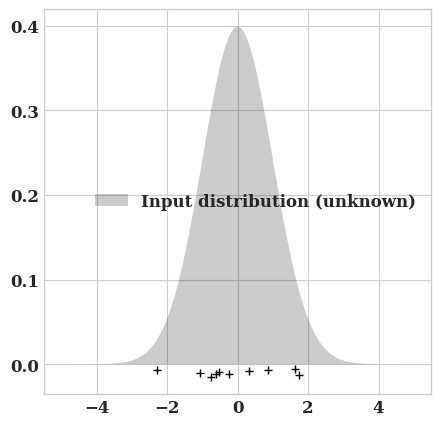

In [7]:
from scipy.stats import norm
np.random.seed(1)
########################################
mu, sigma, N = 0, 1, 10  # mean and standard deviation of the generative process
# when we work in practice we have only points we do not know the generative process.
########################################
# when we work in practice we have only points we do not know the generative process.
points = np.random.normal(mu, sigma, N)
X_plot = np.linspace(-5, 5, 1000)

true_dens = norm(mu, sigma).pdf(X_plot)

fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="Input distribution (unknown)")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
ax.legend()

In [8]:
def estimate_gaussian_mle(points, X_plot, plot=True):
    # Now we estimate with MLE in close form
    mu_mle = points.mean()
    std_mle = np.std(points,ddof=0)
    if plot:
        MLE_dens = norm(mu_mle, std_mle).pdf(X_plot)
        _ = ax.fill(X_plot, MLE_dens, fc="red",
                    alpha=0.2, label="estimated")
    return mu_mle, std_mle

mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

Estimated (-0.09714089080609985, 1.190898552063902) vs Ground-truth (0, 1)


Estimated (-0.09714089080609985, 1.190898552063902) vs Ground-truth (0, 1)


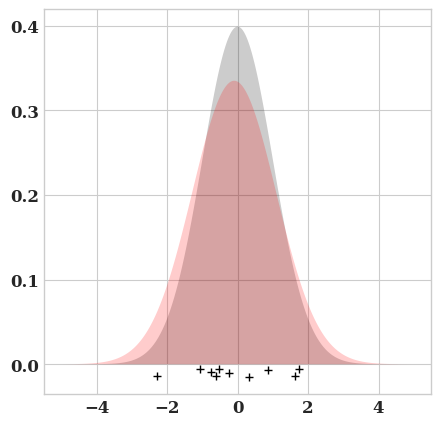

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = ax.fill(X_plot, true_dens, fc="black",
            alpha=0.2, label="input distribution")
_ = ax.plot(points, -0.005 - 0.01 * np.random.random(points.shape[0]), "+k")
mu_mle, std_mle = estimate_gaussian_mle(points, X_plot)
print(f'Estimated ({mu_mle}, {std_mle}) vs Ground-truth ({mu}, {sigma})')

# MLE tends to underestimate the deviation of the Gaussian

<img width="70%" src="figs/MLE_std_biased.png" />

# Problem: What if the data is generated by a multi-modal distribution?

- For example: you are modeling the background for a video-surveillance application, and you have assumed that the background more or less behaves in a **single mode** during the whole day **plus some minor variations**.
    - For example, the background is always *blackish with some minor variations of "black" given by less or more light.*
- You then decide to estimate the parameters **for each pixel** of a single Gaussian using MLE, given a training set of background videos.
- At test-time, you can estimate how probable is a new pixel to be part of the background or foreground by simply estimating the probability of this new pixel to be part of your MLE estimate for that pixel.

# Quick Note on Visualization in 1D/2D with Histograms

# Gaussian

- We decide using **a Gaussian distribution** defined by $\theta=\mathbf{\mu},\mathbf{\Sigma}$
- Even if the training set increases, we are still going to store $\theta=\mathbf{\mu},\mathbf{\Sigma}$

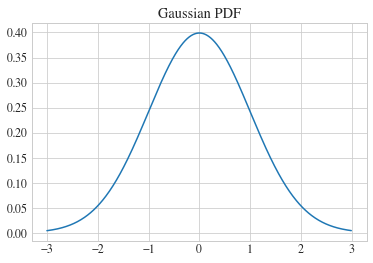

# Histogram

- We could decide to model it with a **normalized histogram**

- In practice, the histogram technique can be useful for obtaining a quick visualization of data in one or two dimensions but is unsuited to most density estimation applications

<img width="110%" src="figs/histogram_binning.png" />

# A single Gaussian for each pixel
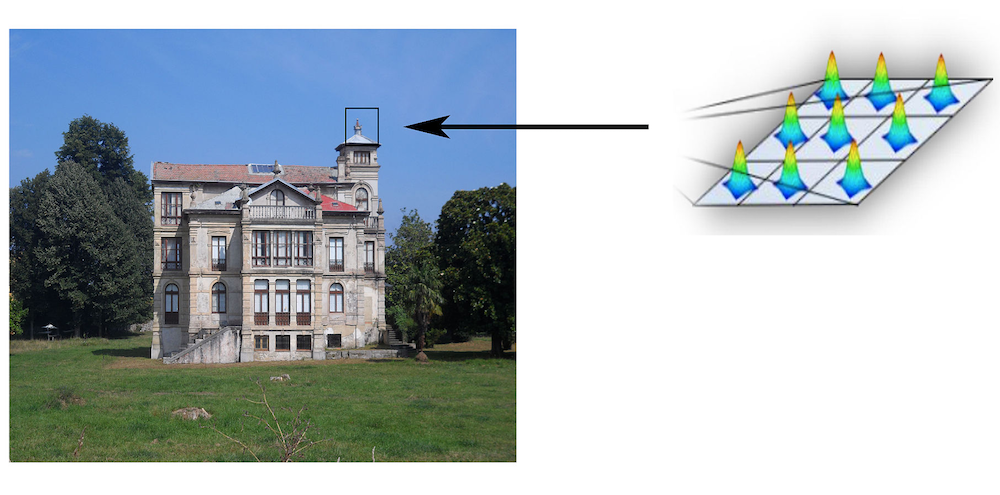

# Why model the background?

<img width="50%" src="https://docs.opencv.org/3.4/Background_Subtraction_Tutorial_Scheme.png" />

# Problem: what if the data is multi-modal?

- By inspecting better the data, you realize that the single mode assumption is **NOT** correct.
- at 3 pm the background is black-ish but then suddenly in the data you have a tree that continuously moves the leaves so that those will be also part of the background
- Your single-mode program will detect each time the leaves as a false alarm and the video-surveillance app won't work well.

# What can we do now?

# A single Gaussian will not work properly

<img width="90%" src="figs/multi_modal.png" />

# Mixture of Gaussians (MoG)

- A Gaussian mixture model represents a distribution as
$$
p(\mathbf{x})=\sum_{k=1}^{K} \colorbox{yellow}{$\pi_{k}$} \mathcal{N}\left(\mathbf{x} \mid \colorbox{yellow}{$\mu_{k}, \Sigma_{k}$}\right)
$$
with $\pi_{k}$ the **mixing coefficients**, where:
$$
\sum_{k=1}^{K} \pi_{k}=1 \quad \text { and } \quad \pi_{k} \geq 0 \quad \forall k
$$
- GMM is a density estimator like the single Gaussian case but handles **multi-modal distributions**
- You can interpret it as a **linear combination** of Gaussians defined by the $\pi_{k}$

# Mixture of Gaussians (MoG)

- We will use a Mixture of Gaussians (MoG) to indicate the distribution used.
- We will use GMM (Gaussian Mixture Model) to indicate the machine learning method behind it.

<img src="figs/three_gaussians.png" />

- It is very powerful and expressive: **GMMs** are **universal approximators of densities** (if you have enough
Gaussians). 
- Even diagonal GMMs are universal approximators

<img src="figs/two_gaussian_a.png" />

[Slide credit: K. Kutulakos]

<img src="figs/two_gaussian_b.png" />

[Slide credit: K. Kutulakos]

# Linear combination of 3 Gaussians in 2D space

- You can think of the first picture from left as $p(\mathbf{x},y)$ the joint density.
- You can think of the second picture from left as $p(\mathbf{x})$  density of all data (marginal).
<img width="75%" src="figs/three_gaussian_3d.png" />

# Interpretation as a Generative Model
From the sum and product rules, we can express the data density $p(\mathbf{x})$ as the marginal density where the marginalization is over the mode/Gaussians we have:
$$
p(\mathbf{x})=\sum_{k=1}^{K} \underbrace{p(k)}_{\text{select mode}} \underbrace{p(\mathbf{x} \mid k)}_{\text{gen. point}}
$$
which is equivalent to MoG equation, in which we can view $\pi_{k}=p(k)$ as the prior probability of picking the $k^{\text {th }}$ component, and the density $\mathcal{N}\left(\mathbf{x} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)=p(\mathbf{x} \mid k)$ as the probability of $\mathbf{x}$ conditioned on $k$.

# Interpretation as a Generative Model

**How can we generate points assuming we have the parameters of the model?**

# Interpretation as a Generative Model

How can we generate points assuming we have a model with $3$ Gaussian where mixing coefficients are $\pi=[0.5, 0.3, 0.2]$;
1. Gaussian k=1 is $\mathbf{\mu}=[0,0]; \mathbf{\Sigma}=[0.5, 0; 0, 0.15]$
1. Gaussian k=2 is $\mathbf{\mu}=[3,2]; \mathbf{\Sigma}=[1.25, 0; 0, 0.75]$
1. Gaussian k=3 is $\mathbf{\mu}=[-2,-2]; \mathbf{\Sigma}=[1, -0.74; -0.74, 1]$

# Generative Model

A possible algorithm is: 
1. sample which Gaussian $\hat{k}$ by inverse transform sampling on the  mixing coefficients $\pi=[0.5, 0.3, 0.2]$
2. Once you know $\hat{k}$, then select the params of the appropriate gaussian and sample $\mathbf{x}\sim\mathcal{N}_{\hat{k}}(\mathbf{\mu},\mathbf{\Sigma})$

# Probabilistic Interpretation

A possible algorithm is: 
1. sample $\mathbf{z} \sim p(\mathbf{z})$ from $\pi=[0.5, 0.3, 0.2]$
2. then sample $\mathbf{x}$ from $p(\mathbf{x}|\mathbf{z})$ that is $\mathbf{x}\sim\mathcal{N}_{\mathbf{z}}(\mathbf{\mu},\mathbf{\Sigma})$

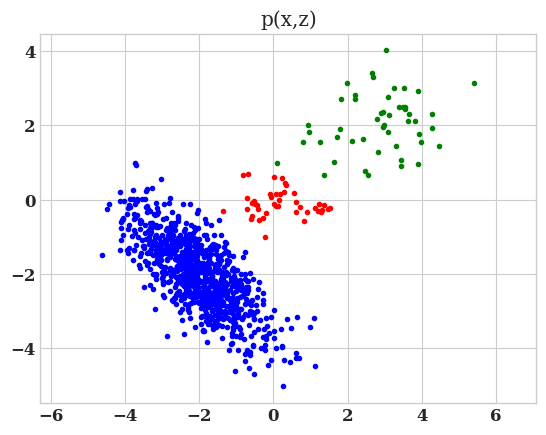

In [10]:
import matplotlib.pyplot as plt
np.random.seed(0)

def inverse_sampling(pmf):
    # import random
    # random.choices(range(1,k), pmf, k=1000)
    return np.argmin((np.random.rand(1)[:, None] > pmf.cumsum()), axis=1)


################### model params #######################
N_samples = 1000  # we sample this amount of points
z_to_gaussian = {0: ([0, 0], [[0.5, 0], [0, 0.15]], 'red'),
                 1: ([3, 2], [[1.25, 0], [0, 0.75]], 'green'),
                 2: ([-2, -2], [[1, -0.74], [-0.74, 1]], 'blue'),
                 }
mixing = np.array([0.05, 0.05, 0.9])  # mixing coefficients
########################################################
for _ in range(0, N_samples):  # for each sample
    z = inverse_sampling(mixing)  # sample k using mixing coefficients
    *normal, color = z_to_gaussian[z[0]]  # now sample the data from  N_k
    x, y = np.random.multivariate_normal(
        *normal, 1).T  # sample 1 point at a time for clarity
    plt.plot(x, y, '.', color=color)
plt.title('p(x,z)')
plt.axis('equal')
plt.show()

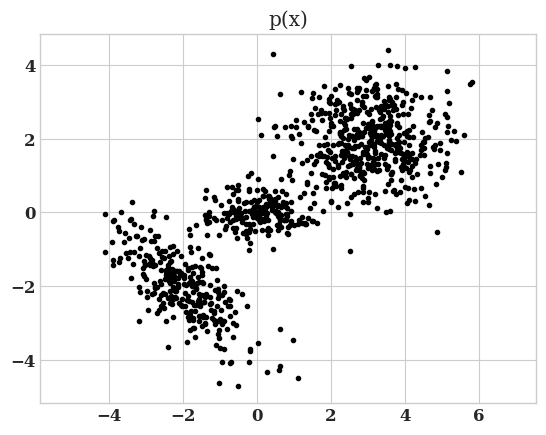

In [11]:
import matplotlib.pyplot as plt
np.random.seed(0)

def inverse_sampling(pmf):
    return np.argmin((np.random.rand(1)[:, None] > pmf.cumsum()), axis=1)


################### model params #######################
N_samples = 1000  # we sample this amount of points
z_to_gaussian = {0: ([0, 0], [[0.5, 0], [0, 0.15]], 'red'),
                 1: ([3, 2], [[1.25, 0], [0, 0.75]], 'green'),
                 2: ([-2, -2], [[1, -0.74], [-0.74, 1]], 'blue'),
                 }
mixing = np.array([0.2, 0.5, 0.3])  # mixing coefficients
########################################################
for _ in range(0, N_samples):  # for each sample
    z = inverse_sampling(mixing)  # sample k using mixing coefficients
    *normal, color = z_to_gaussian[z[0]]  # now sample the data from  N_k
    x, y = np.random.multivariate_normal(
        *normal, 1).T  # sample 1 point at time for clarity
    plt.plot(x, y, '.', color='black')
plt.axis('equal')
plt.title('p(x)')
plt.show()

As we shall see in later chapters, an important role is played by the posterior probabilities $p(k \mid \mathbf{x})$, which are also known as responsibilities. From Bayes' theorem these are given by
$$
\begin{aligned}
\gamma_{k}(\mathbf{x}) & \equiv p(k \mid \mathbf{x}) \\
&=\frac{p(k) p(\mathbf{x} \mid k)}{\sum_{l} p(l) p(\mathbf{x} \mid l)} \\
&=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x} \mid \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)}{\sum_{l} \pi_{l} \mathcal{N}\left(\mathbf{x} \mid \boldsymbol{\mu}_{l}, \boldsymbol{\Sigma}_{l}\right)}
\end{aligned}
$$

# How to fit a Mixture of Gaussians (MoG)

- Remember we always start with a data set of data points $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$
- if we knew the "labels" of the Gaussian and their association with the data points, it would be **EASY** to recover the MoG
- Answer the question `from which Gaussian is this point sampled?` Alas, we do not have the answer to this question.

## Supervised Setting *(uncommon)*

Let's assume $k=3$ Gaussian and $X=\{\mathbf{x}_1,\ldots,\mathbf{x}_N \}$ and $Y=\{{y}_1,\ldots,{y}_N \}$
where $Y$ denotes an index from `0 to k-1` that selects the Gaussian for that point.

If we had, we could do:
- Estimate $K$ parameters $\mathbf{\mu}_k,\mathbf{\Sigma}_k$ by:
    - Performing MLE on all points but selecting those of class $k=0$. 
        - Obtain $\mathbf{\mu}_0,\mathbf{\Sigma}_0$. The red Gaussian before.
    - Performing MLE on all points but selecting those of class $k=1$. 
        - Obtain $\mathbf{\mu}_1,\mathbf{\Sigma}_1$. The green Gaussian before.
    - Performing MLE on all points but selecting those of class $k=2$. 
        - Obtain $\mathbf{\mu}_2,\mathbf{\Sigma}_2$. The blue Gaussian before.
        
**$\colorbox{yellow}{Problem:}$** we **cannot** assume to know the association of the points to Gaussians. (i..e we do not know $Y$).

# How to fit a Mixture of Gaussians (MoG)

We can do MLE on a Mixture of Gaussians:

- Maximum likelihood maximizes
$$
\ln p(\mathbf{X} \mid \pi, \mu, \Sigma)=\sum_{n=1}^{N} \ln \left(\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)\right)
$$
w.r.t $\Theta=\left\{\pi_{k}, \mu_{k}, \Sigma_{k}\right\}$


**Problems:**

- **Singularities**: Arbitrarily large likelihood when a Gaussian explains a single point
- **Identifiability**: the solution is up to permutations
- **No close-form solution**.

# What is a singularity?

A **(trivial)** way of thinking about a data set of points to fit a parametric model or to estimate a density is to:
1. Fit a $\mathbf{\delta}$ **Delta Dirac function** to each point.
2. Scale each delta for the inverse of the number of points we have (to adjust the total area)
3. The sum over the deltas will sum up to 1 and thus will be a probability distribution

This is related to the idea of **overfitting the data** (more on overfitting in supervised learning).
<center>
<img width="20%" src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Dirac_function_approximation.gif" /></center>

# What is a singularity?

- Gaussian with infinitesimal std. deviation centered on the data point (i.e. Delta Dirac on the point) 

$$
\mathcal{N}\left(\mathbf{x}_{n} \mid \mathbf{x}_{n}, \sigma_{j}^{2} \mathbf{I}\right)=\frac{1}{(2 \pi)^{1 / 2}} \frac{1}{\sigma_{j}}
$$

<div align='center'><img src="figs/singularity.png" width='65%' ></div>

# Trivial Solution: Data Density is a Delta Dirac for each point


$$ p(\mathbf{x}) = \frac{1}{N} \sum_{i=1}^N \delta(\mathbf{x}-\mathbf{x}_i) $$

# How to fit a Mixture of Gaussians (MoG)

We can do MLE on a Mixture of Gaussians:

- Maximum likelihood maximizes
$$
\ln p(\mathbf{X} \mid \pi, \mu, \Sigma)=\sum_{n=1}^{N} \ln \left(\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)\right)
$$
w.r.t $\Theta=\left\{\pi_{k}, \mu_{k}, \Sigma_{k}\right\}$


**Assumptions:**

- **No Singularities**
- **No close-form solution**. So we will implement an iterative solution.

# How to fit a Mixture of Gaussians (MoG)
### Trick 1: Use a latent variable $z$ to indicate the Gaussian selected
### Trick 2: Express the data density as the marginalization of the latent variable


$$
p(\mathbf{x})=\sum_z \underbrace{p(\mathbf{z})}_{\text{select mode}} \underbrace{p(\mathbf{x} \mid \mathbf{z})}_{\text{gen. point}}
$$

## Latent Variable

- Some model variables may be unobserved, either at training, at test time, or both 
- If occasionally unobserved they are missing, e.g., undefined inputs, missing class labels, erroneous targets
- Variables that are always unobserved are called **latent variables, or sometimes hidden variables**

- We may want to intentionally introduce latent variables to model complex dependencies between variables – this can simplify the model

- In a mixture model, the identity of the component that generated a given data point is a latent variable

# Expectation Maximization (EM) for MoG

- EM is an **elegant and powerful method for finding maximum likelihood solutions for models with latent variables** in an interactive way.
- It can be applied to other models not only to MoG.
- You will find immediately that will resemble **K-means**

It is made of two steps:
1. **Expectation step (E-step):**
     - We assume we have a good initialization/version of the weights $\{\mathbf{\mu}_k,\mathbf{\Sigma}_k,\mathbf{\pi_k}\}_k$ (same problem of initialization has K-means).
     - To adjust the parameters, we must first solve the inference problem. **Which Gaussian generated each data point?**
     -  Compute the **posterior probability that each Gaussian generates each data point** (as this is unknown to us)
     - Given a data point, what is the probability $\mathbf{x}$ comes from Gaussian $\mathbf{z}==k$?
      $$ \text{Compute} \quad p(\mathbf{z} | \mathbf{x}; \mathbf{\mu},\mathbf{\Sigma},\mathbf{\pi})$$

2. **Maximization step (M-step):**
     - **Assuming that the data really was generated this way, change the parameters of each Gaussian to maximize the probability that it would generate the data it is currently responsible for**
     - Each Gaussian gets a certain amount of posterior probability for each data point
     -  At the optimum we shall satisfy $\frac{\partial \ln p(\mathbf{X} \mid \pi, \mu, \Sigma)}{\partial \Theta}=0$
     - We can derive closed-form updates for all parameters <ins>**in this step only**</ins>

<img width='75%' src="figs/em_step_a.png" />

# E-step: Posterior Prob. and Responsibilities

Given a data point, what is the probability comes from Gaussian $\mathbf{z}==k$?
- We apply Bayes Theorem in the middle

$$
p(\mathbf{z} | \mathbf{x} ) = \frac{p(\mathbf{x} | \mathbf{z}) p(\mathbf{z})}{p(\mathbf{x})} =  \frac{p(\mathbf{x} | \mathbf{z}) p(\mathbf{z})}{\sum_z p(\mathbf{x} | \mathbf{z}) p(\mathbf{z})}
$$

Given a data point, what is the probability comes from Gaussian $\mathbf{z}==k$?

$$
\gamma_{k} = p(\mathbf{z}=k | \mathbf{x}) =  \frac{p(\mathbf{x} | \mathbf{z}=k) p(\mathbf{z}=k)}{p(\mathbf{x})} =  \frac{p(\mathbf{x} | \mathbf{z}=k) p(\mathbf{z}=k)}{\sum_j^K p(\mathbf{x} | \mathbf{z}=j) p(\mathbf{z}=j)}
$$

$$
\gamma_{k} = \frac{\colorbox{yellow}{$p(\mathbf{x} | \mathbf{z}=k) p(\mathbf{z}=k)$}}{\sum_j^K p(\mathbf{x} | \mathbf{z}=j) p(\mathbf{z}=j)}
$$

$$\underbrace{p(\mathbf{x} | \mathbf{z}=k)}_{\text{generation}}\underbrace{p(\mathbf{z}=k)}_{\text{selection}}$$

$$
\underbrace{p(\mathbf{x} | \mathbf{z}=k)}_{\text{generation}}\underbrace{p(\mathbf{z}=k)}_{\text{selection}} = \mathcal{N}(\mathbf{x};\mathbf{\mu}_k,\mathbf{\Sigma}_k)\cdot\pi_k
$$

# Responsibilities

$$\gamma_{k} =\frac{
 \mathcal{N}(\mathbf{x};\mathbf{\mu}_k,\mathbf{\Sigma}_k)\cdot\pi_k}
{\sum_j\mathcal{N}(\mathbf{x};\mathbf{\mu}_j,\mathbf{\Sigma}_j)\cdot\pi_j}
$$

- The **responsibility that component $k$ takes for ‘explaining’ the observation x**
- For a data point, $\mathbf{\gamma}$ is $1\times K$ i.e. `[0.8, 0.1, 0.1]` for 3 Gaussians
    - It means that 80% of the data is explained by 1st Gaussian.
    - It means that 10% of the data is explained by 2nd Gaussian.
    - It means that 10% of the data is explained by 3rd Gaussian.


# Responsibilities are on the right-most figure
<img width='75%' src="figs/em_step_a.png" />

# Responsibilities are Soft-Assignments

- Soft-Assignment means an association of points to clusters
- For $N$ data point is a matrix $N\times K$
- Note the strong similarities in computing distances in K-means (but here we do **soft-assignments**)!

# Maximization Step

- Log-likelihood:
$$
\ln p(\mathbf{X} \mid \pi, \mu, \Sigma)=\sum_{n=1}^{N} \ln \left(\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)\right)
$$
- Set derivatives to zero:
$$
\frac{\partial \ln p(\mathbf{X} \mid \pi, \mu, \Sigma)}{\partial \mu_{k}}=0$$
- for $\mathbf{\mu}_k,\mathbf{\Sigma}_k,\pi_k$

# Maximization Step
$$
-\sum_{n=1}^{N} \underbrace{\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x} \mid \mu_{j}, \Sigma_{j}\right)}}_{\gamma_{nk}}\Sigma_{k}^{-1}\left(\mathbf{x}^{(n)}-\mu_{k}\right) = 0
$$
- We used:
$$
\mathcal{N}(\mathbf{x} \mid \mu, \Sigma)=\frac{1}{\sqrt{(2 \pi)^{d}|\Sigma|}} \exp \left(-\frac{1}{2}(\mathbf{x}-\mu)^{T} \Sigma^{-1}(\mathbf{x}-\mu)\right)
$$
and:
$$
\frac{\partial\left(\mathbf{x}^{T} A \mathbf{x}\right)}{\partial \mathbf{x}}=\mathbf{x}^{T}\left(A+A^{T}\right)
$$

# Maximization Step $\mathbf{\mu}_k$
- This gives
$$
\mu_{k}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{k}^{(n)} \mathbf{x}^{(n)}
$$
with $N_{k}$ the effective number of points in cluster $k$
$$
N_{k}=\sum_{n=1}^{N} \gamma_{k}^{(n)}
$$
- We just take the center-of-gravity of the data that the Gaussian is responsible for
- Just like in K-means, **except the data is weighted by the posterior probability of the Gaussian.**
- Guaranteed to lie in the convex hull of the data (Could be a big initial jump)

# Maximization Step $\mathbf{\Sigma}_k$

- We can similarly get the expression for the variance
$$
\Sigma_{k}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{k}^{(n)}\left(\mathbf{x}^{(n)}-\mu_{k}\right)\left(\mathbf{x}^{(n)}-\mu_{k}\right)^{T}
$$
- We can also minimize w.r.t the mixing coefficients
$$
\pi_{k}=\frac{N_{k}}{N}, \quad \text { with } \quad N_{k}=\sum_{n=1}^{N} \gamma_{k}^{(n)}
$$
- The optimal mixing proportion to use (given these posterior probabilities) is just the **fraction of the data that the Gaussian gets responsibility for.**
- Note that this is not a closed-form solution of the parameters, as they depend on the responsibilities $\gamma_{k}^{(n)}$, which are complex functions of the parameters
- But we have a simple iterative scheme to optimize

# EM Algorithm for GMM
- Initialize the means $\mu_{k}$, covariances $\Sigma_{k}$ and mixing coefficients $\pi_{k}$
- Iterate until convergence:
- E-step: Evaluate the responsibilities given current parameters
$$
\gamma_{k}^{(n)}=p\left(z^{(n)} \mid \mathbf{x}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{j}, \Sigma_{j}\right)}
$$
- M-step: Re-estimate the parameters given current responsibilities
$$
\begin{aligned}
&\mu_{k}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{k}^{(n)} \mathbf{x}^{(n)} \\
&\Sigma_{k}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{k}^{(n)}\left(\mathbf{x}^{(n)}-\mu_{k}\right)\left(\mathbf{x}^{(n)}-\mu_{k}\right)^{T} \\
&\pi_{k}=\frac{N_{k}}{N} \text { with } N_{k}=\sum_{n=1}^{N} \gamma_{k}^{(n)}
\end{aligned}
$$
- Evaluate log likelihood and check for convergence
$$
\ln p(\mathbf{X} \mid \pi, \mu, \Sigma)=\sum_{n=1}^{N} \ln \left(\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}^{(n)} \mid \mu_{k}, \Sigma_{k}\right)\right)
$$

<img width="70%" src="figs/em_step_b.png" />

# Let's try this out on 2D sample dataset

# We assume we know the generative process

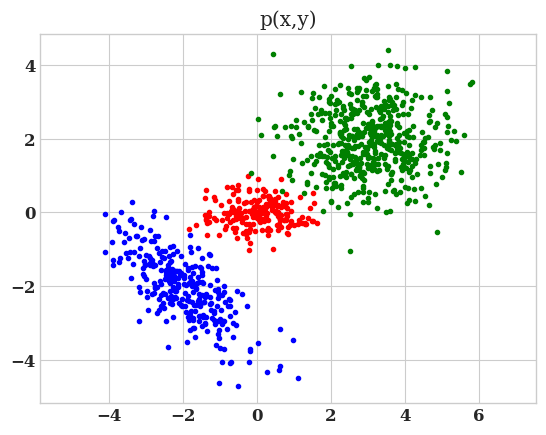

In [12]:
import matplotlib.pyplot as plt
np.random.seed(0)


def inverse_sampling(pmf):
    return np.argmin((np.random.rand(1)[:, None] > pmf.cumsum()), axis=1)


################### model params #######################
N_samples = 1000  # we sample this amount of points
z_to_gaussian = {0: ([0, 0], [[0.5, 0], [0, 0.15]], 'red'),
                 1: ([3, 2], [[1.25, 0], [0, 0.75]], 'green'),
                 2: ([-2, -2], [[1, -0.74], [-0.74, 1]], 'blue'),
                 }
mixing = np.array([0.2, 0.5, 0.3])  # mixing coefficients
X = None
########################################################
for _ in range(0, N_samples):  # for each sample
    z = inverse_sampling(mixing)  # sample k using mixing coefficients
    *normal, color = z_to_gaussian[z[0]]  # now sample the data from  N_k
    x, y = np.random.multivariate_normal(
        *normal, 1).T  # sample 1 point at a time for clarity
    plt.plot(x, y, '.', color=color)
    X = np.array( [x, y]) if X is None else np.hstack((X, [x, y]))
plt.title('p(x,y)')
plt.axis('equal')
plt.show()

# ...but the input is this!

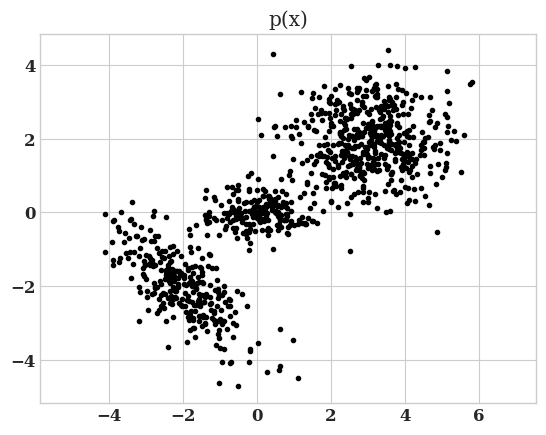

In [13]:
import matplotlib.pyplot as plt
np.random.seed(0)

def inverse_sampling(pmf):
    return np.argmin((np.random.rand(1)[:, None] > pmf.cumsum()), axis=1)


################### model params #######################
N_samples = 1000  # we sample this amount of points
z_to_gaussian = {0: ([0, 0], [[0.5, 0], [0, 0.15]], 'red'),
                 1: ([3, 2], [[1.25, 0], [0, 0.75]], 'green'),
                 2: ([-2, -2], [[1, -0.74], [-0.74, 1]], 'blue'),
                 }
mixing = np.array([0.2, 0.5, 0.3])  # mixing coefficients
########################################################
for _ in range(0, N_samples):  # for each sample
    z = inverse_sampling(mixing)  # sample k using mixing coefficients
    *normal, color = z_to_gaussian[z[0]]  # now sample the data from  N_k
    x, y = np.random.multivariate_normal(
        *normal, 1).T  # sample 1 point at a time for clarity
    plt.plot(x, y, '.', color='black')
plt.axis('equal')
plt.title('p(x)')
plt.show()

# Learning!

In [14]:
from sklearn.mixture import GaussianMixture
# X is 2xN
gmm = GaussianMixture(n_components=3, random_state=0).fit(X.T)
# >>> gm.means_ #Dxk
assignments = gmm.predict(X.T)

# Now we can do multiple things: 1) clustering

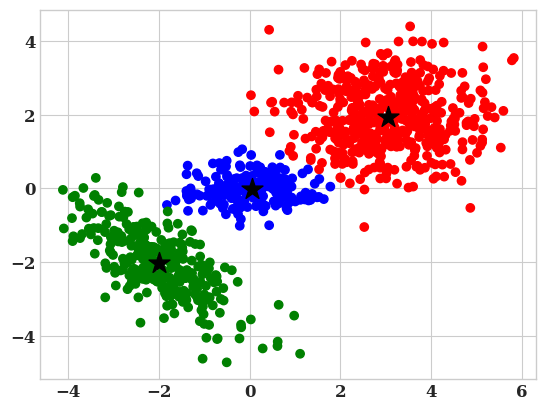

In [15]:
z_to_col = {0: 'red', 1: 'green', 2: 'blue'}
_ = plt.scatter(X[0, ...], X[1, ...], color=[z_to_col[y] for y in assignments])
_ = plt.scatter(*gmm.means_.T,
                  s=250,
                  marker='*',
                  c='black',
                  label='centroids')

# Note that we have recovered the labels automatically!

# Now we can do multiple things: 1) density estimators 2) anomaly detection
### You cannot do this with k-means

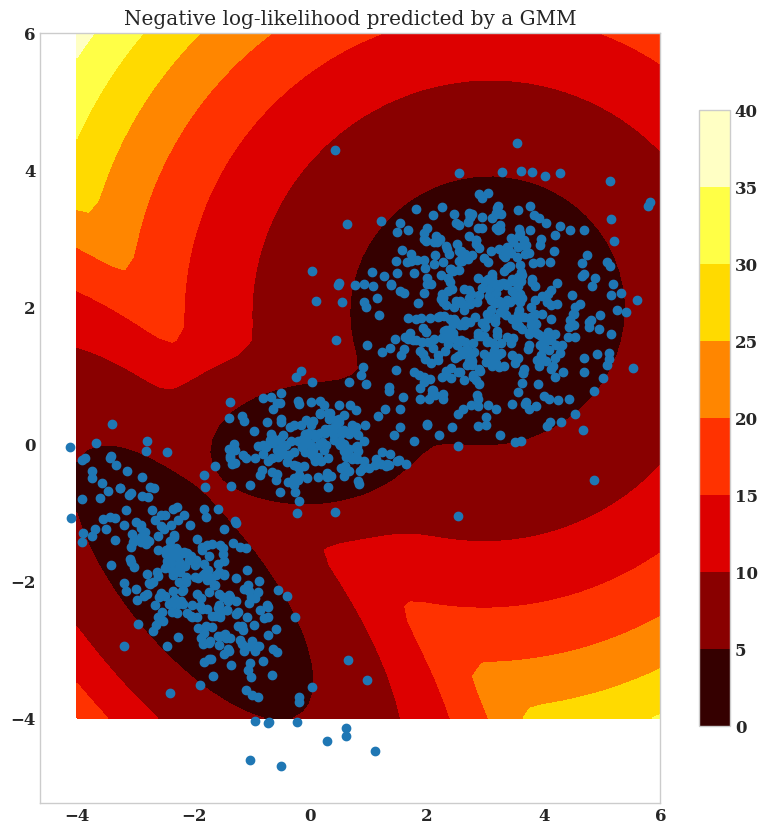

In [16]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10, 10))
# display predicted scores by the model as a contour plot
x = np.linspace(-4.0, 6.0)
y = np.linspace(-4.0, 6.0)
X1, Y1 = np.meshgrid(x, y)
XX = np.array([X1.ravel(), Y1.ravel()]).T
Z = -gmm.score_samples(XX)  # negative log likelihood
Z = Z.reshape(X1.shape)

CS = plt.contourf(
    X1, Y1, Z, cmap='hot'
)
plt.grid(False)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X[0, ...],  X[1, ...])

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()

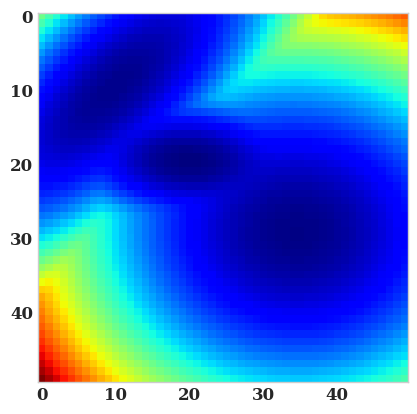

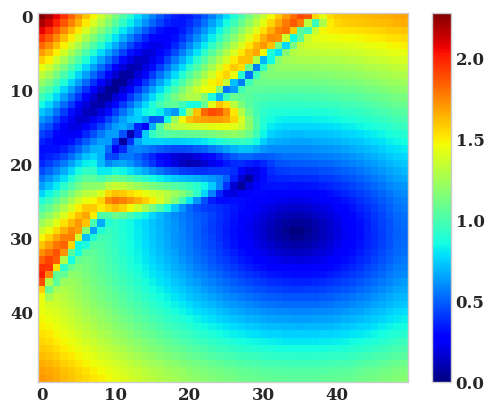

In [17]:
gx, gy = np.gradient(Z)
fig = plt.figure()
plt.grid(False)
plt.imshow(Z, cmap='jet')
fig = plt.figure()
plt.grid(False)
norm_grad = (gx**2+gy**2)**.5
plt.imshow(norm_grad-norm_grad.min(), cmap='jet')
plt.colorbar()

# Now we can do multiple things: 3) we can also generate (sample) data as we showed before

## We just have to sample from the parameters that we have now estimated!

# Motivating GMM: Weaknesses of K-Means

This part is taken from this [tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

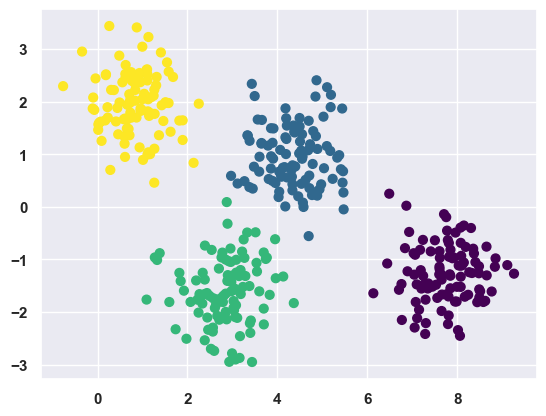

In [19]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

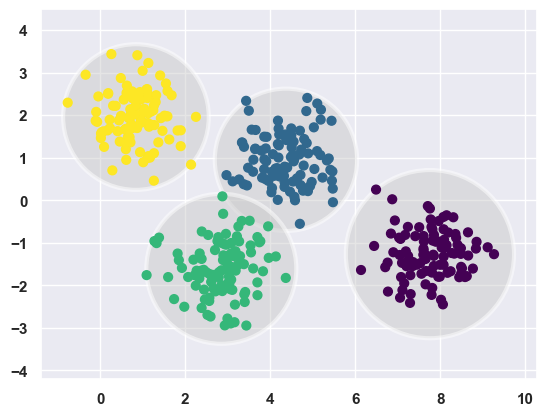

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

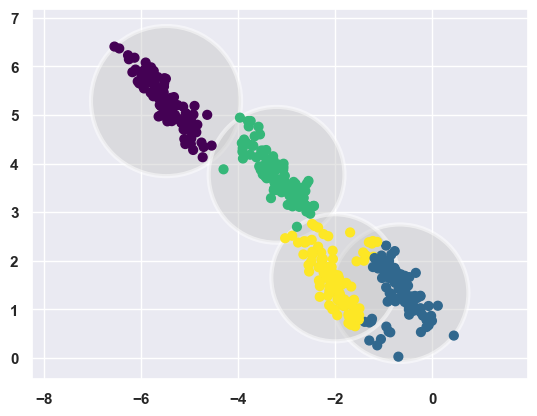

In [21]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In [22]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

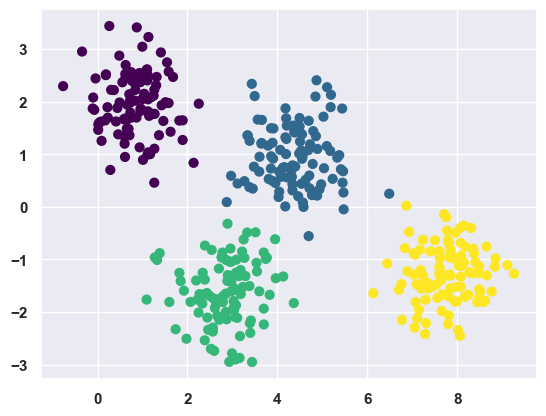

In [23]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

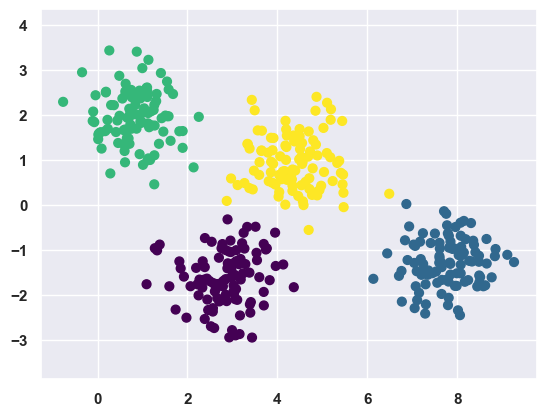

In [24]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

# Covariance Type

**GMM** can have assumptions even on the shape of the Gaussian based on the covariance matrix.

**Remember:** 
- $\mathbf{\mu}$ indicates where to place the Gaussian (acts as a translation in space);
- $\mathbf{\Sigma}$ instead models the shape of each Gaussian

$\mathbf{\Sigma}$ types:
- `full`: **each component** has its own general covariance matrix **(more parameters)**
- `tied`: **all components** share the same general covariance matrix.
- `diag` **each component** has its own diagonal covariance matrix.
- `spherical`: **each component** has its own single variance. **(less params)**

### Note: It is common to decorrelate the data with PCA so that then you can assume a diagonal matrix (less params!)

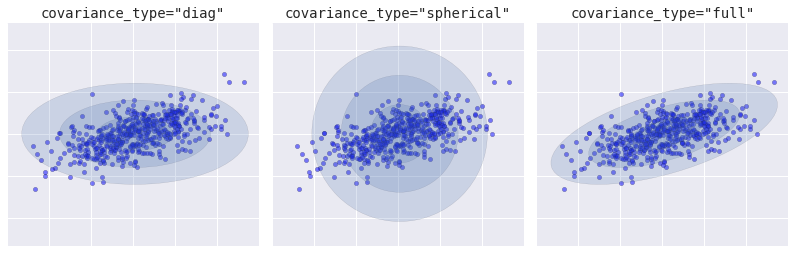

# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">


## GMM as Density Estimator

# GMM as Density Estimator

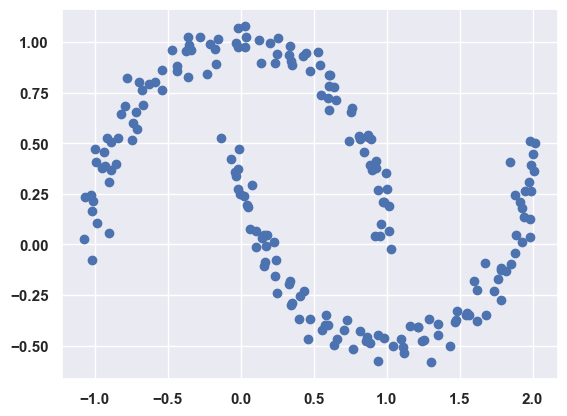

In [25]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

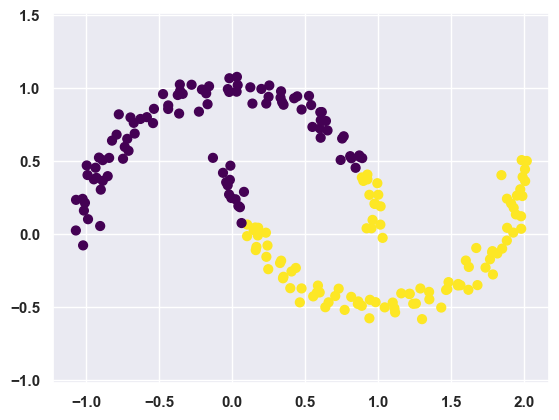

In [26]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

# With two components does not fit the data well

# let's try with 8 and full covariance matrices!

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

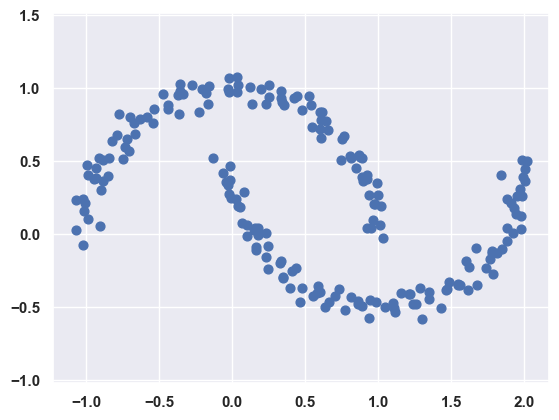

In [27]:
gmm16 = GaussianMixture(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

# GMM models the overall distribution of the data

- Here the mixture of **8 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data.**
- This is a **generative model of the distribution**, meaning that the **GMM gives us the recipe to generate new random data distributed similarly to our input**. 
- For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

# We can sample from the estimated distribution

Note that **sample** means **generate**

In [ ]:
Xnew, _ = gmm16.sample(4000)
plot_gmm(gmm16, Xmoon, label=True)
plt.scatter(Xnew[:, 0], Xnew[:, 1], color='red')

# we can even sample more points and plot their log-likelihood

In [ ]:
Xnew, _ = gmm16.sample(40000)
loglike = gmm16.score_samples(Xnew)
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=loglike, cmap='jet')

# How many components? (similar to K-means)

- The fact that **GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.**
- A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. 
- Another means of correcting for over-fitting is to adjust the model likelihoods using **some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC).**
- Scikit-Learn's GMM estimator includes built-in methods that compute both of these, so it is very easy to operate on this approach.

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# A generative model on real data

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='gray')
        im.set_clim(0, 16)
plot_digits(digits.data)

## The input dimension is D-64. We can try to compress it for better speed

- We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more. 
- GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data. 
- Here we will use a straightforward **PCA, asking it to preserve 99% of the variance in the projected data**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=False)
data = pca.fit_transform(digits.data)
data.shape

# 64 dimensions to 41
- The result is 41 dimensions, a reduction of nearly 1/3 with almost no variance loss. 
- Given this projected data, let's use the BIC to get a gauge for the number of GMM components we should use.

# Lets' now use BIC regularization to decide the number of components

- Note by doing this we have to run the algorithm for how many components we need to try.

In [ ]:
n_components = np.arange(1, 40, 1)
models = [GaussianMixture(n, covariance_type='diag', random_state=0)
          for n in n_components]
aics = [model.fit(data).bic(data) for model in models]
plt.plot(n_components, aics);

# We will use 10 components (because we know we have 10 digits!)

# We could hope that each Gaussian model the digit class!

In [ ]:
idx = (n_components==10).nonzero()[0][0]
model = models[idx]

# Now let's generate (sample) 100 new data points

In [ ]:
data_new, y_new = model.sample(100)
data_new.shape

# Now from subspace to the Input space

In [ ]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

# These digits _[should]_ not exist in the initial dataset!

# GMM Model Debug

In [ ]:
plt.bar(*np.unique(digits.target, return_counts=True));

In [ ]:
plt.bar(range(10),model.weights_);

In [ ]:
plt.bar(range(model.means_[0].shape[0]),model.means_[0]);

# For example, you can check if the mean is very close to a training point

In [ ]:
plt.bar(range(model.means_[0].shape[0]),model.covariances_[0]);

# You could debug covariance to spot potential singularities (though sklearn may avoid that)

# Homework 3

- Fit a GMM "manually" using the labels provided by `digits.target` with `K=10`
- Fit now the same GMM without labels and debug/confront the parameters of the models
- Try to draw some conclusions regarding the difference